In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import pearsonr
%matplotlib inline

1. Consider data set 1 (ds1.csv). The data set comprises observations (the Five xs) along with three sequences that may or may not be generated from the observations.

1a. Describe the data set in a few sentences.  E.g.   What are the distributions of each observation?  Summary statistics?


,x1,x2,x3,x5,x6,ya,yb,yc
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,5.011059,-3.005565,2.500593,0.999136,0.000647,3.827867,2.111854,1.022765e-04
std,2.873568,2.000799,1.752906,1.002006,4.663860,18.438514,0.769306,3.121215e-02
min,0.000015,-12.498524,-3.489212,0.000003,-13.885453,-64.021995,-0.523672,-5.433613e-01
25%,2.536309,-4.353844,1.189920,0.285629,-2.611943,-8.998020,1.580212,-2.423158e-03
50%,5.022191,-3.002649,2.503764,0.690903,-0.000611,2.666992,2.231057,-5.670000e-10
75%,7.486275,-1.649283,3.802236,1.386862,2.621841,15.579687,2.733318,2.476745e-03
max,9.999887,6.089820,8.679097,15.102966,13.924740,107.713997,3.841363,8.183882e-01


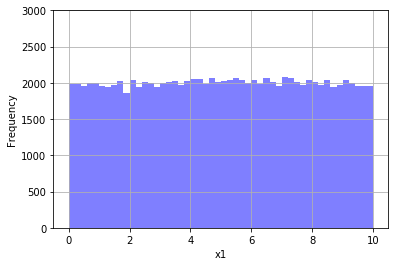

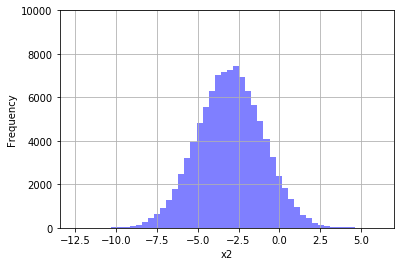

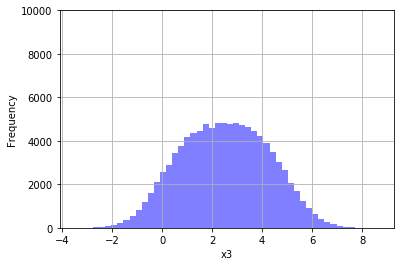

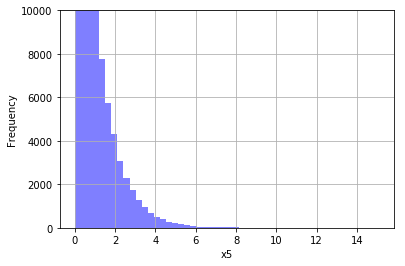

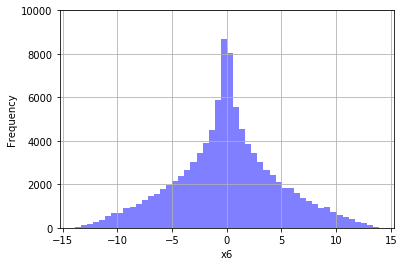

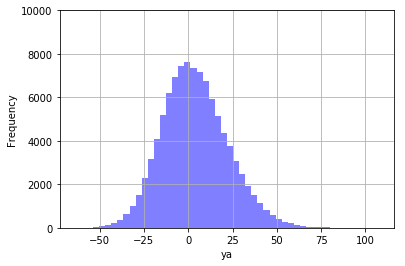

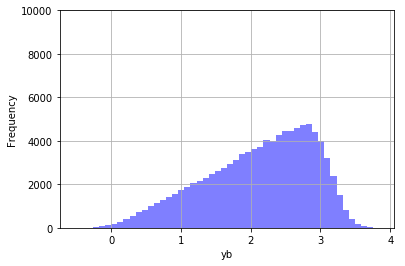

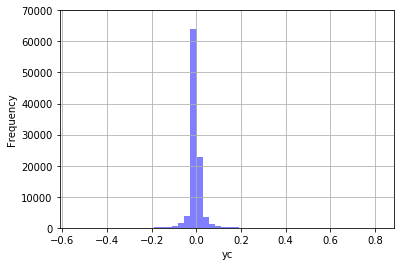

In [78]:
file_name = "data/ds1.csv"
raw_df = pd.read_csv(file_name, header = 0, index_col = 0)
display(raw_df.describe())
#display(raw_df)


def hist_plot(variable, num_bins, x_label, y_lim) :
    
    ''' Plots a frequency histogram on a variable given y-axis limits and numbers of bins
        
        variable = list of values
        num_bins = positive integer (x-axis)
        x_label = x-axis label
        y_lim = y axis min and max ordered pair'''
    
    n, bins, patches = plt.hist(variable, num_bins, facecolor='blue', alpha=0.5)
    plt.ylabel('Frequency')
    plt.xlabel(x_label)
    plt.grid(True)
    plt.ylim(y_lim)
    plt.show()
    
def prob_hist_plot(variable, num_bins, x_label) :
    
    '''Plots a frequency probability histogram on a variable given values'''
    
    plt.hist(variable, bins = num_bins, density = True, alpha = 0.5, histtype = 'stepfilled', 
             color = 'steelblue', edgecolor = 'none')
    plt.ylabel('Frequency Probability')
    plt.xlabel(x_label)
    plt.grid(True)
    plt.show()

hist_plot(raw_df.x1, 50, 'x1', (0, 3000))
hist_plot(raw_df.x2, 50, 'x2', (0, 10000))
hist_plot(raw_df.x3, 50, 'x3', (0, 10000))
hist_plot(raw_df.x5, 50, 'x5', (0, 10000))
hist_plot(raw_df.x6, 50, 'x6', (0, 10000))
hist_plot(raw_df.ya, 50, 'ya', (0, 10000))
hist_plot(raw_df.yb, 50, 'yb', (0, 10000))
hist_plot(raw_df.yc, 50, 'yc', (0, 70000))

# prob_hist_plot(raw_df.x1, 50, 'x1')
# prob_hist_plot(raw_df.x2, 50, 'x2')
# prob_hist_plot(raw_df.x3, 50, 'x3')
# prob_hist_plot(raw_df.x5, 50, 'x5')
# prob_hist_plot(raw_df.x6, 50, 'x6')
# prob_hist_plot(raw_df.ya, 50, 'ya')
# prob_hist_plot(raw_df.yb, 50, 'yb')
# prob_hist_plot(raw_df.yc, 50, 'yc')


b) Try to come up with a predictive model, e.g.  y = f(x_1 + … + x_n) for each y sequence.   Describe your model and how you came up with them.   What (if any) are the predictive variables?  How good would you say each of your models is?


In [79]:
#Use standard scaler to get dataframe into a more friendly format for model building (i.e. force dataset to be normally distributed)

#Create new dataframe without target variables
x_cols = ['x1', 'x2', 'x3', 'x5', 'x6']
raw_df_x = raw_df[x_cols]
display(raw_df_x)

#Create instance of StandardScaler() object
scaler = StandardScaler()

#fit to a dataset - stores mean and std from raw_df dataset into the scaler object for later use
scaler.fit(raw_df_x)

#Create a new dataframe with the rescaled features (0 - mean, unit variance)
data_clean = pd.DataFrame(scaler.transform(raw_df_x), index = raw_df_x.index, columns = raw_df_x.columns)

#Add target variables to scaled dataframe
data_clean['ya'] = raw_df['ya']
data_clean['yb'] = raw_df['yb']
data_clean['yc'] = raw_df['yc']
data_clean_x = data_clean.drop(['ya', 'yb', 'yc'], axis = 1)
display(data_clean)

#Create separate dataframes for each target variable
data_clean_ya = data_clean.drop(['yb', 'yc'], axis = 1)
data_clean_yb = data_clean.drop(['ya', 'yc'], axis = 1)
data_clean_yc = data_clean.drop(['ya', 'yb'], axis = 1)

#display(data_clean_yc)


#Split three sets into training/testing/validation

def ttv(test_pct, v_split, rndm_st, x, y) :
    
    '''function ttv splits dataset according to:
    
        test_pct = test split % wrt training set
        v_split = val split wrt test set
        rndm_st = random state divying up into each set input
        x = feature values
        y = target variable values'''
    
    x_train, x_test1, y_train, y_test1 = train_test_split(x, y, test_size=test_pct, random_state=rndm_st)
    x_test, x_val, y_test, y_val = train_test_split(x_test1, y_test1, test_size = v_split, random_state=rndm_st)
    return x_train, x_test, x_val, y_train, y_test, y_val

xa_train, xa_test, xa_val, ya_train, ya_test, ya_val = ttv(0.2, 0.5, 1, data_clean_x, data_clean.ya)
xb_train, xb_test, xb_val, yb_train, yb_test, yb_val = ttv(0.2, 0.5, 1, data_clean_x, data_clean.yb)
xc_train, xc_test, xc_val, yc_train, yc_test, yc_val = ttv(0.2, 0.5, 1, data_clean_x, data_clean.yc)

#display(yc_train)


,x1,x2,x3,x5,x6
1,2.642583,-1.715220,1.909334,0.027139,-3.447187
2,4.588761,-2.507543,4.239107,1.704150,-2.782809
3,7.919796,-5.108415,3.039451,0.992815,5.551587
4,2.616757,-2.124040,2.855570,0.990079,1.694697
5,3.300856,-5.159684,0.764544,0.143581,3.277496
6,5.198411,-4.515175,4.066355,0.207562,1.009529
7,3.581187,-1.672175,2.264740,0.613397,-2.781569
8,8.221096,2.403445,4.783215,0.450347,-7.534506
9,1.084227,-3.303455,2.074846,1.281347,-0.608101
10,5.862929,-5.145815,2.420512,0.539825,3.552033


,x1,x2,x3,x5,x6,ya,yb,yc
1,-0.824233,0.644918,-0.337304,-0.970056,-0.739270,13.630850,1.828765,8.385607e-03
2,-0.146960,0.248913,0.991795,0.703606,-0.596817,7.834582,2.162110,7.960000e-06
3,1.012244,-1.051011,0.307410,-0.006308,1.190209,-5.107041,2.797083,-5.030000e-06
4,-0.833220,0.440588,0.202509,-0.009040,0.363231,19.015046,1.953887,3.801705e-02
5,-0.595153,-1.076635,-0.990388,-0.853846,0.702608,-9.818862,1.922446,1.178275e-03
6,0.065199,-0.754508,0.893243,-0.789993,0.216320,-10.861335,2.157967,-1.817425e-03
7,-0.497597,0.666432,-0.134550,-0.384969,-0.596551,10.353647,1.961150,3.249130e-04
8,1.117097,2.703439,1.302199,-0.547693,-1.615655,76.918119,3.280467,7.055861e-02
9,-1.366542,-0.148887,-0.242882,0.281646,-0.130525,-21.162219,0.759512,-2.236635e-02
10,0.296452,-1.069703,-0.045685,-0.458394,0.761473,-12.703518,2.354059,-3.046840e-04


Feature Reduction - Eliminating features based on pearson correlation

In [80]:
#Determine linear correlation between variables

def pearson_corr(features, y, feature_names, y_name) :
    
    ''' Function to calculate pearson correlation estimates for 
        a list of feature values compared to target variable values
        
        features = list of feature values
        y = target variable values
        feature_names = list of feature names
        y_name = string of target variable name'''

    xa_pear = list()
    for item in features :
        pear = pearsonr(item, y)[0]
        xa_pear.append(pear)
    pear_df = pd.DataFrame(data = xa_pear, index = feature_names, columns = ['pearson_corr_' + y_name ])
    return pear_df

xa_trainlst = [xa_train.x1, xa_train.x2, xa_train.x3, xa_train.x5, xa_train.x6]
xb_trainlst = [xb_train.x1, xb_train.x2, xb_train.x3, xb_train.x5, xb_train.x6]
xc_trainlst = [xc_train.x1, xc_train.x2, xc_train.x3, xc_train.x5, xc_train.x6]

pear_a = pearson_corr(xa_trainlst, ya_train, xa_train.columns, 'ya')
pear_b = pearson_corr(xb_trainlst, yb_train, xb_train.columns, 'yb')
pear_c = pearson_corr(xc_trainlst, yc_train, xc_train.columns, 'yc')
result = pd.concat([pear_a, pear_b, pear_c], axis=1, sort=False)
display(result)

,pearson_corr_ya,pearson_corr_yb,pearson_corr_yc
x1,0.464772,0.945753,0.003429
x2,0.675994,-0.001757,0.000234
x3,0.411936,0.775427,0.000508
x5,0.003243,0.007163,0.002365
x6,0.002546,0.004031,-0.000416


It appears that x5 and x6 do not have a linear relationship with ya, yb, or yc.  Also, it appears that x2 is not correlated with yb and none of x1, x2, x3, x5, x6 are correlated with yc.

Therefore, the following feature sets will be used for each modeling iteration:
ya: full set, full set less x5 and x6
yb: full set, full set less x2, x5, x6
yc: Would predict that regardless of the feature sets selected, yc will be difficult to model because of the low correlation indications

In [82]:
#creating new feature sets after feature reduction

xa_train_fr = xa_train.drop(['x5', 'x6'], axis = 1)
xa_test_fr =  xa_test.drop(['x5', 'x6'], axis = 1)
xa_val_fr =   xa_val.drop(['x5', 'x6'], axis = 1)

xb_train_fr = xb_train.drop(['x2','x5', 'x6'], axis = 1)
xb_test_fr =  xb_test.drop(['x2','x5', 'x6'], axis = 1)
xb_val_fr =   xb_val.drop(['x2','x5', 'x6'], axis = 1)

In [83]:
#SVM SVR

#Generate different lists of hypertuning parameters

kern = ['linear', 'rbf', 'sigmoid']
#kern = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

#Hypertuning for a
#Csa = [10**exp for exp in range (-5,5)]
#gammasa = [10**exp for exp in range (-5,5)]
#Csa = [1000, 3500, 6500, 10000, 11000]

#final a
Csa = [10000, 11000, 12000, 13000]
gammasa = [0.001, 0.005, 0.01, 0.05, 0.1]

#Hypertuning for b
# Csb = [10**exp for exp in range (-5,5)]
# gammasb = [10**exp for exp in range (-5,5)]

#Final b
Csb = [1000,5000,10000, 11000, 12000, 13000]
gammasb = [0.001, 0.005, 0.01, 0.05, 0.1]

#Hypertuning for c
Csc = [10**exp for exp in range (-3,3)]
gammasc = [10**exp for exp in range (-3,3)]

#display(hp_grid)

def svm_grd(kern, Cs, gammas, x_train, y_train, x_test, y_test) :
    
    ''' runs svm given inputs
        kern = kernel
        Cs = list of C values
        gammas = list of gamma values (won't effect if linear kernel)'''
    
    hp_grid = pd.DataFrame(index = Cs, columns = gammas)
    for cee in Cs :
        for gam in gammas :
            clf = svm.SVR(kernel = kern, C = cee , gamma = gam)
            clf.fit(x_train[:100], y_train[:100]) 
            ya_pred = clf.predict(x_test[:100])
            mse = mean_squared_error(y_test[:100], ya_pred)
            #print("C = ", cee, "Gamma = ", gam)
            #display(mse)
            hp_grid[gam][cee] = mse           
    return hp_grid
    #c_opt = hp_grid.idxmin(axis = 0)
    #gam_opt = hp_grid.idxmin(axis = 1)
    #display(hp_grid[gam_opt][c_opt])
    #mean_absolute_error(ya_test[:10000], ya_pred)

print('a')
for k in kern :
    display(svm_grd(k, Csa, gammasa, xa_train, ya_train, xa_test, ya_test))
    display(svm_grd(k, Csa, gammasa, xa_train_fr, ya_train, xa_test_fr, ya_test))

print('b')
for k in kern :
    display(svm_grd(k, Csb, gammasb, xb_train, yb_train, xb_test, yb_test))
    display(svm_grd(k, Csb, gammasb, xb_train_fr, yb_train, xb_test_fr, yb_test))

print('c')
for k in kern :
    display(svm_grd(k, Csc, gammasc, xc_train, yc_train, xc_test, yc_test))

a


,0.001,0.005,0.01,0.05,0.1
10000,149.241,149.241,149.241,149.241,149.241
11000,149.237,149.237,149.237,149.237,149.237
12000,149.23,149.23,149.23,149.23,149.23
13000,149.224,149.224,149.224,149.224,149.224


,0.001,0.005,0.01,0.05,0.1
10000,140.838,140.838,140.838,140.838,140.838
11000,140.842,140.842,140.842,140.842,140.842
12000,140.844,140.844,140.844,140.844,140.844
13000,140.847,140.847,140.847,140.847,140.847


,0.001,0.005,0.01,0.05,0.1
10000,148.27,138.269,146.622,346.814,414.025
11000,148.311,138.59,147.535,354.501,427.807
12000,148.509,138.764,148.522,363.371,441.328
13000,148.726,138.946,149.268,372.766,458


,0.001,0.005,0.01,0.05,0.1
10000,142.641,131.295,126.287,140.731,145.484
11000,142.349,130.445,126.026,140.748,146.983
12000,142.311,130.142,126.051,140.625,148.801
13000,142.551,130.102,126.157,140.515,151.026


,0.001,0.005,0.01,0.05,0.1
10000,149.305,149.755,162.32,260275,6.51354e+06
11000,149.302,149.899,173.882,383811,1.20124e+07
12000,149.303,149.937,178.493,456964,1.18328e+07
13000,149.308,149.962,183.663,437207,1.2535e+07


,0.001,0.005,0.01,0.05,0.1
10000,140.487,141.108,141.402,52495.9,2.54604e+06
11000,140.487,141.111,141.618,62944.3,3.08019e+06
12000,140.487,141.114,142.372,74507.1,3.66516e+06
13000,140.827,141.117,142.582,87051.2,4.30096e+06


b


,0.001,0.005,0.01,0.05,0.1
1000,0.0735236,0.0735236,0.0735236,0.0735236,0.0735236
5000,0.0738045,0.0738045,0.0738045,0.0738045,0.0738045
10000,0.074087,0.074087,0.074087,0.074087,0.074087
11000,0.0741933,0.0741933,0.0741933,0.0741933,0.0741933
12000,0.0741533,0.0741533,0.0741533,0.0741533,0.0741533
13000,0.0741904,0.0741904,0.0741904,0.0741904,0.0741904


,0.001,0.005,0.01,0.05,0.1
1000,0.0744132,0.0744132,0.0744132,0.0744132,0.0744132
5000,0.0742986,0.0742986,0.0742986,0.0742986,0.0742986
10000,0.0742626,0.0742626,0.0742626,0.0742626,0.0742626
11000,0.0741808,0.0741808,0.0741808,0.0741808,0.0741808
12000,0.0741303,0.0741303,0.0741303,0.0741303,0.0741303
13000,0.0741702,0.0741702,0.0741702,0.0741702,0.0741702


,0.001,0.005,0.01,0.05,0.1
1000,0.057825,0.0581264,0.0642462,0.141384,0.179193
5000,0.0562939,0.0626596,0.101343,0.277104,0.19807
10000,0.0558687,0.0690921,0.110906,0.282357,0.19807
11000,0.0558126,0.0707876,0.111447,0.283643,0.19807
12000,0.055877,0.0727235,0.113087,0.284578,0.19807
13000,0.0558361,0.0747061,0.115497,0.286769,0.19807


,0.001,0.005,0.01,0.05,0.1
1000,0.0592305,0.0551214,0.0545312,0.0591184,0.0438508
5000,0.0552577,0.0545169,0.0542209,0.0440738,0.0466818
10000,0.0548419,0.0538581,0.0535678,0.0440821,0.0475106
11000,0.0547439,0.053741,0.0536073,0.0441701,0.0474279
12000,0.0543913,0.0537458,0.0537862,0.043851,0.047344
13000,0.0544076,0.0537054,0.0540744,0.0438502,0.047394


,0.001,0.005,0.01,0.05,0.1
1000,0.0739001,0.0766705,0.296243,2554.72,52685.5
5000,0.073969,0.154378,6.59858,64396.7,1.31785e+06
10000,0.0737968,0.439892,23.3579,255644,7.91576e+06
11000,0.073858,0.538081,32.1247,311784,9.95056e+06
12000,0.0738201,0.656278,38.0084,323607,1.07088e+07
13000,0.0739156,0.744907,44.4009,435486,1.25679e+07


,0.001,0.005,0.01,0.05,0.1
1000,0.074411,0.0746323,0.0711843,339.228,17255.9
5000,0.074833,0.0715264,0.603118,8287.94,430690
10000,0.0745267,0.0731298,2.46974,33097.7,1.72241e+06
11000,0.0745121,0.0743047,3.03507,40042.3,2.08407e+06
12000,0.0745063,0.0765693,3.59371,47647.8,2.48018e+06
13000,0.0744751,0.0770739,4.16336,55914.1,2.91073e+06


c


,0.001,0.01,0.1,1.0,10.0,100.0
0.001,0.0013076,0.0013076,0.0013076,0.0013076,0.0013076,0.0013076
0.010,0.00136865,0.00136865,0.00136865,0.00136865,0.00136865,0.00136865
0.100,0.00136865,0.00136865,0.00136865,0.00136865,0.00136865,0.00136865
1.000,0.00136865,0.00136865,0.00136865,0.00136865,0.00136865,0.00136865
10.000,0.00136865,0.00136865,0.00136865,0.00136865,0.00136865,0.00136865
100.000,0.00136865,0.00136865,0.00136865,0.00136865,0.00136865,0.00136865


,0.001,0.01,0.1,1.0,10.0,100.0
0.001,0.00132806,0.00132741,0.0013237,0.00132328,0.00132234,0.00132207
0.010,0.00132737,0.0013214,0.00130368,0.00130352,0.00129279,0.00129059
0.100,0.00132112,0.00132394,0.00132461,0.00130352,0.00129279,0.00129059
1.000,0.00132909,0.00136037,0.00132461,0.00130352,0.00129279,0.00129059
10.000,0.00136775,0.00136037,0.00132461,0.00130352,0.00129279,0.00129059
100.000,0.00136775,0.00136037,0.00132461,0.00130352,0.00129279,0.00129059


,0.001,0.01,0.1,1.0,10.0,100.0
0.001,0.0013281,0.00132775,0.00132448,0.00131308,0.0013065,0.00130744
0.010,0.00132775,0.00132443,0.00130759,0.00134934,0.00133486,0.00134029
0.100,0.00132443,0.0013076,0.00136745,0.00134934,0.00133486,0.00134029
1.000,0.0013076,0.00136863,0.00136745,0.00134934,0.00133486,0.00134029
10.000,0.00136865,0.00136863,0.00136745,0.00134934,0.00133486,0.00134029
100.000,0.00136865,0.00136863,0.00136745,0.00134934,0.00133486,0.00134029


In [85]:
#DT regressor

max_d = [None, 20, 200]

#ya hypertuning
#min_splta = [2**exp for exp in range (1,10)]
#min_lfa = [2**exp for exp in range (0,10)]
#min_lfa = [10 + add for add in range (0,6)]

#Final ya hypertuning
min_splta = [2**exp for exp in range (1,10)]
min_lfa = [13 + add for add in range (0,3)]

#yb hypertuning
# min_spltb = [2**exp for exp in range (1,10)]
# min_lfb = [2**exp for exp in range (0,10)]

#Final yb hypertuning
min_spltb = [2 + add for add in range (0,6)]
min_lfb = [2 + add for add in range (0,6)]

def dt_grd(max_d, min_splt, min_lf, x_train, y_train, x_test, y_test) :
    
    ''' runs dt regressor given inputs
        max_d = max depth
        min_splt = list of minimum_samples_split values
        min_lf = list of minimum_leaf_samples values'''
    
    hp_grid = pd.DataFrame(index = min_splt, columns = min_lf)
    for splt in min_splt :
        for lf in min_lf :
            dtc = DecisionTreeRegressor(max_depth= max_d, min_samples_split=splt, min_samples_leaf=lf)
            dtc.fit(x_train[:100], y_train[:100]) 
            ya_pred = dtc.predict(x_test[:100])
            mse = mean_squared_error(y_test[:100], ya_pred)
            #print("splt = ", splt, "leaf = ", lf)
            #display(mse)
            hp_grid[lf][splt] = mse           
    return hp_grid

print("a")
for d in max_d :
    print(d)
    display(dt_grd(d, min_splta, min_lfa, xa_train, ya_train, xa_test, ya_test))
    display(dt_grd(d, min_splta, min_lfa, xa_train_fr, ya_train, xa_test_fr, ya_test))

print("b")
for d in max_d :
    print(d)
    display(dt_grd(d, min_spltb, min_lfb, xb_train, yb_train, xb_test, yb_test))
    display(dt_grd(d, min_spltb, min_lfb, xb_train_fr, yb_train, xb_test_fr, yb_test))


a
None


,13,14,15
2,210.275,206.034,206.16
4,210.275,206.034,206.16
8,210.275,206.034,206.16
16,210.275,206.034,206.16
32,210.275,206.034,206.16
64,290.021,290.021,290.021
128,392.022,392.022,392.022
256,392.022,392.022,392.022
512,392.022,392.022,392.022


,13,14,15
2,210.275,206.034,206.16
4,210.275,206.034,206.16
8,210.275,206.034,206.16
16,210.275,206.034,206.16
32,210.275,206.034,206.16
64,290.021,290.021,290.021
128,392.022,392.022,392.022
256,392.022,392.022,392.022
512,392.022,392.022,392.022


20


,13,14,15
2,210.275,206.034,206.16
4,210.275,206.034,206.16
8,210.275,206.034,206.16
16,210.275,206.034,206.16
32,210.275,206.034,206.16
64,290.021,290.021,290.021
128,392.022,392.022,392.022
256,392.022,392.022,392.022
512,392.022,392.022,392.022


,13,14,15
2,210.275,206.034,206.16
4,210.275,206.034,206.16
8,210.275,206.034,206.16
16,210.275,206.034,206.16
32,210.275,206.034,206.16
64,290.021,290.021,290.021
128,392.022,392.022,392.022
256,392.022,392.022,392.022
512,392.022,392.022,392.022


200


,13,14,15
2,210.275,206.034,206.16
4,210.275,206.034,206.16
8,210.275,206.034,206.16
16,210.275,206.034,206.16
32,210.275,206.034,206.16
64,290.021,290.021,290.021
128,392.022,392.022,392.022
256,392.022,392.022,392.022
512,392.022,392.022,392.022


,13,14,15
2,210.275,206.034,206.16
4,210.275,206.034,206.16
8,210.275,206.034,206.16
16,210.275,206.034,206.16
32,210.275,206.034,206.16
64,290.021,290.021,290.021
128,392.022,392.022,392.022
256,392.022,392.022,392.022
512,392.022,392.022,392.022


b
None


,2,3,4,5,6,7
2,0.0814144,0.0755151,0.075172,0.0686225,0.0686935,0.0674138
3,0.0814807,0.0775092,0.075172,0.0686225,0.0686935,0.0674138
4,0.0782789,0.0775107,0.075172,0.0686225,0.0686935,0.0674138
5,0.0816548,0.0775092,0.075172,0.0686225,0.0686935,0.0674138
6,0.0764917,0.0779763,0.075172,0.0686225,0.0686935,0.0674138
7,0.0796056,0.076507,0.075172,0.0686225,0.0686935,0.0674138


,2,3,4,5,6,7
2,0.0902924,0.0823225,0.0814777,0.0665718,0.0679916,0.0683002
3,0.0907011,0.0823225,0.0814777,0.0665718,0.0679916,0.0683002
4,0.0919004,0.082363,0.0814777,0.0665718,0.0679916,0.0683002
5,0.0851566,0.0823189,0.0814777,0.0665718,0.0679916,0.0683002
6,0.0828928,0.0823189,0.0814777,0.0665718,0.0679916,0.0683002
7,0.0811377,0.0819875,0.0814777,0.0665718,0.0679916,0.0683002


20


,2,3,4,5,6,7
2,0.0821648,0.076816,0.075172,0.0686225,0.0686935,0.0674138
3,0.0783299,0.0777367,0.075172,0.0686225,0.0686935,0.0674138
4,0.0790013,0.0759822,0.075172,0.0686225,0.0686935,0.0674138
5,0.0822934,0.0775107,0.075172,0.0686225,0.0686935,0.0674138
6,0.0764917,0.0770436,0.075172,0.0686225,0.0686935,0.0674138
7,0.0780103,0.076507,0.075172,0.0686225,0.0686935,0.0674138


,2,3,4,5,6,7
2,0.0874862,0.0823225,0.0814777,0.0665718,0.0679916,0.0683002
3,0.0912104,0.0823225,0.0814777,0.0665718,0.0679916,0.0683002
4,0.0886855,0.0823225,0.0814777,0.0665718,0.0679916,0.0683002
5,0.0822787,0.082363,0.0814777,0.0665718,0.0679916,0.0683002
6,0.0828928,0.082363,0.0814777,0.0665718,0.0679916,0.0683002
7,0.0808529,0.0819875,0.0814777,0.0665718,0.0679916,0.0683002


200


,2,3,4,5,6,7
2,0.0785673,0.0752891,0.075172,0.0686225,0.0686935,0.0674138
3,0.0758538,0.0779763,0.075172,0.0686225,0.0686935,0.0674138
4,0.0790678,0.0755151,0.075172,0.0686225,0.0686935,0.0674138
5,0.0823877,0.0755151,0.075172,0.0686225,0.0686935,0.0674138
6,0.0784462,0.0777367,0.075172,0.0686225,0.0686935,0.0674138
7,0.0796056,0.0781022,0.075172,0.0686225,0.0686935,0.0674138


,2,3,4,5,6,7
2,0.0907011,0.0823189,0.0814777,0.0665718,0.0679916,0.0683002
3,0.0874862,0.082363,0.0814777,0.0665718,0.0679916,0.0683002
4,0.0914916,0.082363,0.0814777,0.0665718,0.0679916,0.0683002
5,0.0848754,0.082363,0.0814777,0.0665718,0.0679916,0.0683002
6,0.0835146,0.0823189,0.0814777,0.0665718,0.0679916,0.0683002
7,0.0811377,0.0819875,0.0814777,0.0665718,0.0679916,0.0683002


In [115]:
#Gradient Boosting Regressor

def oob_gbr(x_train, y_train, x_test, y_test) :
    gbr = GradientBoostingRegressor(max_depth = 2, min_samples_leaf = 2, min_samples_split = 5, n_estimators = 76, learning_rate = 0.1)
    gbr.fit(x_train[:100], y_train[:100]) 
    y_pred = gbr.predict(x_test[:100])
    mse = mean_squared_error(y_test[:100], y_pred)
    return mse

display(oob_gbr(xa_train, ya_train, xa_test, ya_test))
display(oob_gbr(xa_train_fr, ya_train, xa_test_fr, ya_test))

144.2228809155316

136.4532579757057

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,8.677829,11.716801,9.252817,-2.679634,2.774942,0.077631,8.200884,8.712878,-12.860135,-1.339360
std,11.971827,6.655333,9.861443,10.625164,8.800553,15.375478,10.426023,9.881482,8.881026,14.534143
min,-25.824199,-8.497562,-23.666439,-29.429655,-22.033329,-35.264019,-21.428538,-16.811146,-36.065150,-36.468083
25%,0.231327,7.161564,2.648845,-10.652694,-4.098043,-14.003670,-0.812888,1.480706,-19.430697,-13.216190
50%,12.754335,11.896021,11.422441,-2.631318,2.484416,1.500838,8.532535,9.628064,-14.417786,-2.094310
75%,17.364337,16.279210,16.503676,5.340314,9.660898,14.050512,17.138898,16.081044,-6.534142,10.561797
max,32.268570,32.909917,31.230550,26.422798,29.312010,31.727042,32.084297,36.847922,13.553705,32.641789


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
1,23.778224,13.319974,15.565124,-3.713626,7.296793,-19.371013,-0.894130,-6.110282,-28.959316,2.851336
2,16.602950,23.311281,21.099052,-0.304154,-3.218990,2.357643,12.027277,7.070349,-5.762185,-23.050198
3,12.084683,19.710443,9.837102,-1.081918,-1.201942,9.738019,16.125920,19.119391,-15.582122,-12.292535
4,13.044534,10.749040,5.884407,-11.703525,-4.134358,-22.344666,-1.263349,0.493711,-15.305347,6.799087
5,8.314115,6.748794,5.388535,-0.000290,-4.724787,-16.346812,3.293600,-10.848273,-17.285491,6.034214
6,12.720842,14.505106,8.539374,-9.798877,-3.441879,-13.792778,-0.873655,-0.582209,-21.778693,5.960885
7,18.333179,10.601186,10.858774,-0.106563,-3.723256,-23.084135,-2.449055,-0.225368,-12.143918,0.244593
8,12.212042,11.895612,16.578703,-10.905597,-5.427663,-18.549143,3.574704,-6.709803,-15.263314,-1.430924
9,20.574983,6.830524,18.026900,-16.175381,15.713618,-8.109950,-1.557623,1.601867,-21.433860,18.250094
10,19.834167,0.983827,21.499509,-3.832573,0.690054,10.086488,20.447429,7.763797,-8.272261,-20.346943


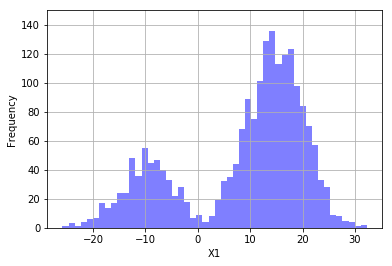

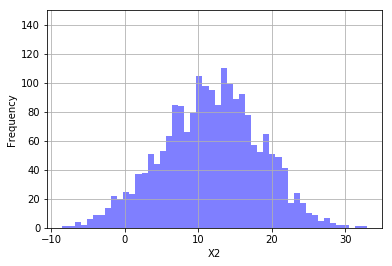

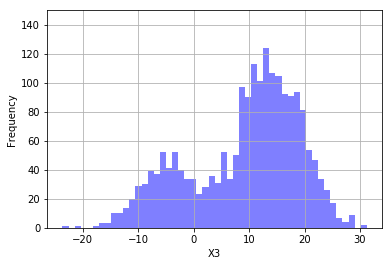

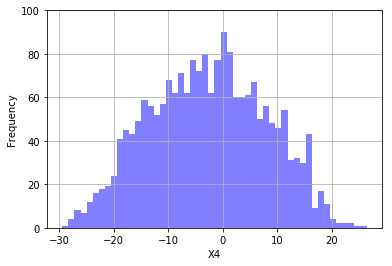

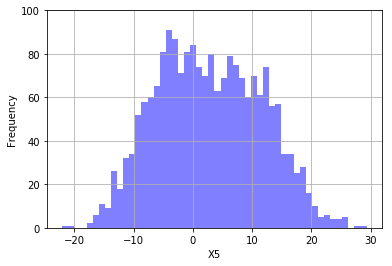

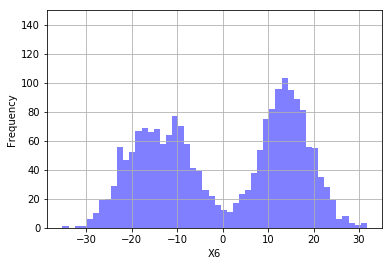

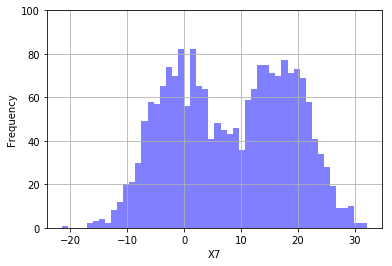

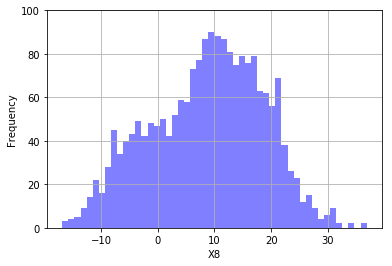

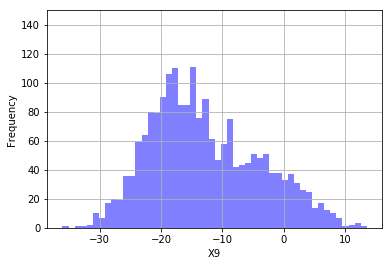

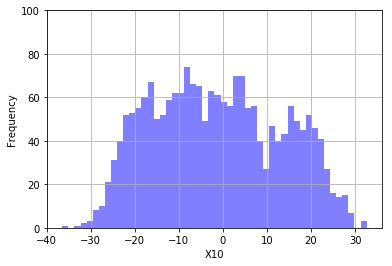

In [32]:
#Data set 2

file_name_2 = "data/ds2.csv"
raw_df2 = pd.read_csv(file_name_2, header = 0, index_col = 0)
display(raw_df2.describe())
display(raw_df2)

hist_plot(raw_df2.X1, 50, 'X1', (0, 150))
hist_plot(raw_df2.X2, 50, 'X2', (0, 150))
hist_plot(raw_df2.X3, 50, 'X3', (0, 150))
hist_plot(raw_df2.X4, 50, 'X4', (0, 100))
hist_plot(raw_df2.X5, 50, 'X5', (0, 100))
hist_plot(raw_df2.X6, 50, 'X6', (0, 150))
hist_plot(raw_df2.X7, 50, 'X7', (0, 100))
hist_plot(raw_df2.X8, 50, 'X8', (0, 100))
hist_plot(raw_df2.X9, 50, 'X9', (0, 150))
hist_plot(raw_df2.X10, 50, 'X10', (0, 100))



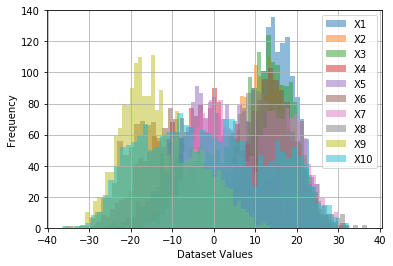

In [40]:
def hist_plots(variable_list, num_bins, x_labels, y_lim) :
    
    ''' Plots a frequency histogram on a variable given y-axis limits and numbers of bins
        
        variable_list = list of variable list values
        num_bins = positive integer (x-axis)
        x_labels = list of x-axis labels
        y_lim = y axis min and max ordered pair'''
    
    i = 0
    for variable in variable_list :
        n, bins, patches = plt.hist(variable, num_bins, alpha=0.5, label = x_labels[i])
        i += 1
    
    plt.ylabel('Frequency')
    plt.xlabel("Dataset Values")
    plt.grid(True)
    plt.ylim(y_lim)
    plt.legend(loc='upper right')
    plt.show()

variable_list = [raw_df2.X1, raw_df2.X2, raw_df2.X3, raw_df2.X4, raw_df2.X5, raw_df2.X6, raw_df2.X7, raw_df2.X8, raw_df2.X9, raw_df2.X10]
num_bins = 50
x_labels = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
y_lim = (0, 140)

hist_plots(variable_list, num_bins, x_labels, y_lim)